In [2]:
import glob
import os
from lsst import afw
print(afw.version.__version__)
from lsst.daf.persistence import Butler
from lsst.eotest.sensor import MaskedCCD, makeAmplifierGeometry
import numpy

from exploreRun import exploreRun
from lsst.eo_utils.base.image_utils import get_ccd_from_id,\
    get_amp_list, get_data_as_read, sort_sflats

from lsst.eo_utils.base.data_access import get_data_for_run

import lsst.eotest.image_utils as imutil
import pylab

from astropy.io import fits
from astropy.stats import mad_std
import numpy as np

import scipy
from scipy import signal
from scipy.fftpack import fft, fftshift
import matplotlib.pyplot as plt

import math
from scipy.ndimage import gaussian_filter

%matplotlib inline

20.0.0-4-gde602ef96+1


[ 319.994  324.969  349.982  374.975  400.019  424.965  450.035  475.003
  500.018  525.002  550.029  575.023  599.982  619.997  624.979  650.012
  675.004  700.03   725.012  750.022  774.987  799.976  824.988  850.022
  869.967  875.002  899.999  919.999  925.012  949.965  975.002  999.976
 1025.028 1050.014 1075.002 1099.99 ]
[0.00000000e+000 0.00000000e+000 6.02562418e-277 1.30739184e-228
 1.21148028e-184 7.11944804e-146 3.02382453e-111 1.08944657e-081
 1.52397759e-056 3.94966546e-036 2.74339844e-020 3.89408303e-009
 1.25588740e-002 9.43638875e-001 9.52558239e-001 1.61231863e-003
 6.20880101e-011 5.28099940e-023 1.04766134e-039 4.59087746e-061
 5.43700854e-087 1.55385810e-117 7.36116708e-153 6.05725044e-193
 1.00906785e-227 1.60551096e-237 1.05105196e-286 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]


Text(0.5, 1.0, 'Response Curve/SED for CCOB$_{R}$')

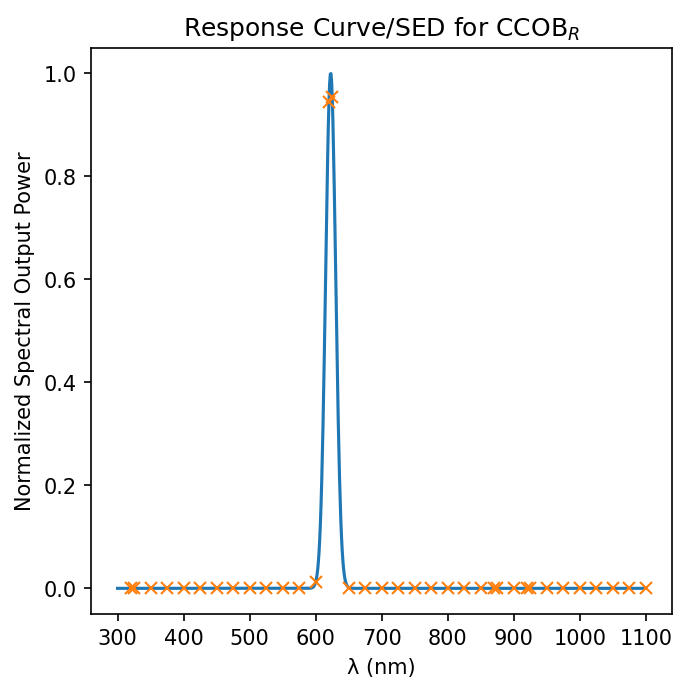

In [3]:
superbiaspath = "/gpfs/slac/lsst/fs1/u/echarles/DATA/analysis/ts8/superbias/RTM-024/RTM-024-11351-S11_superbias_normal.fits"
superdarkpath = "/gpfs/slac/lsst/fs1/u/echarles/DATA/analysis/ts8/superdark/RTM-024/RTM-024-11351-S11_superdark_normal.fits"
qeflatpath = glob.glob("/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-11021_RTM/LCA-11021_RTM-024/11351/qe_raft_acq/v0/88290/S11/*_lambda_flat_*") 
qeflatpath.sort()


# array of wavelengths
wls = numpy.array([ get_ccd_from_id(None, aqeflatpath, []).md.md["MONOWL"] for aqeflatpath in qeflatpath ])
print(wls)



# SED plot for red band
fig, axs = pylab.subplots(figsize=(5,5),dpi=150)

wavelengths_list = [365, 466.6, 622.6, 759.9, 845.7, 950.5]
width_of_wavelength_list = [12, 25, 18, 28, 32, 60]
width_of_wavelength_list_converted = []
for num in width_of_wavelength_list:
    z = num / 2.355
    width_of_wavelength_list_converted.append(z)
# now wavelength widths converted from FWHM to sigma


# want to use the RED band, so the third element in each list
mu = wavelengths_list[2]
sigma = width_of_wavelength_list_converted[2]

a = 1    # to normalize
x = numpy.arange(300,1100,1)  
y = a*numpy.exp(-(x-mu)**2/(2*sigma**2))
pylab.plot(x, y)

weights = numpy.interp(wls, x, y)   
print(weights)
# plots 'x's
pylab.plot(wls, weights,"x")

pylab.xlabel("λ (nm)")
pylab.ylabel("Normalized Spectral Output Power")
pylab.title("Response Curve/SED for CCOB$_{R}$")

In [4]:
import numpy as np
import matplotlib.pyplot as plt

superdark = get_ccd_from_id(None, superdarkpath, [])     # load superdark
superbias = get_ccd_from_id(None, superbiaspath, [])     # load superbias


num_ch  = 16    
img_list_top_row = []
img_list_bottom_row = []
MEAN = None

for ch in range(num_ch):
    arr = []       
    for i, aqeflatpath in enumerate(qeflatpath):
        aqeflat = get_ccd_from_id(None, aqeflatpath, [], bias_frame=superbias)
    
        img = aqeflat.unbiased_and_trimmed_image(ch + 1).getImage().array
        if MEAN is None:              # this will keep only one number for the normalization.
            MEAN = img.mean()
        img = img/MEAN     # this will normalize your image

        arr.append(img*weights[i])
        arr.append(img*weights[i])
        
    img = numpy.sum(arr,axis=0)/numpy.sum(weights) 
    std = mad_std(img)
    N = 3
        
    if ch < num_ch / 2:
        img_list_bottom_row.append(img)    # working with E2V sensors not, not ITL so flipped bottom and top row here
    else:
        img_list_top_row.append(img)

img_list_bottom_row.reverse()

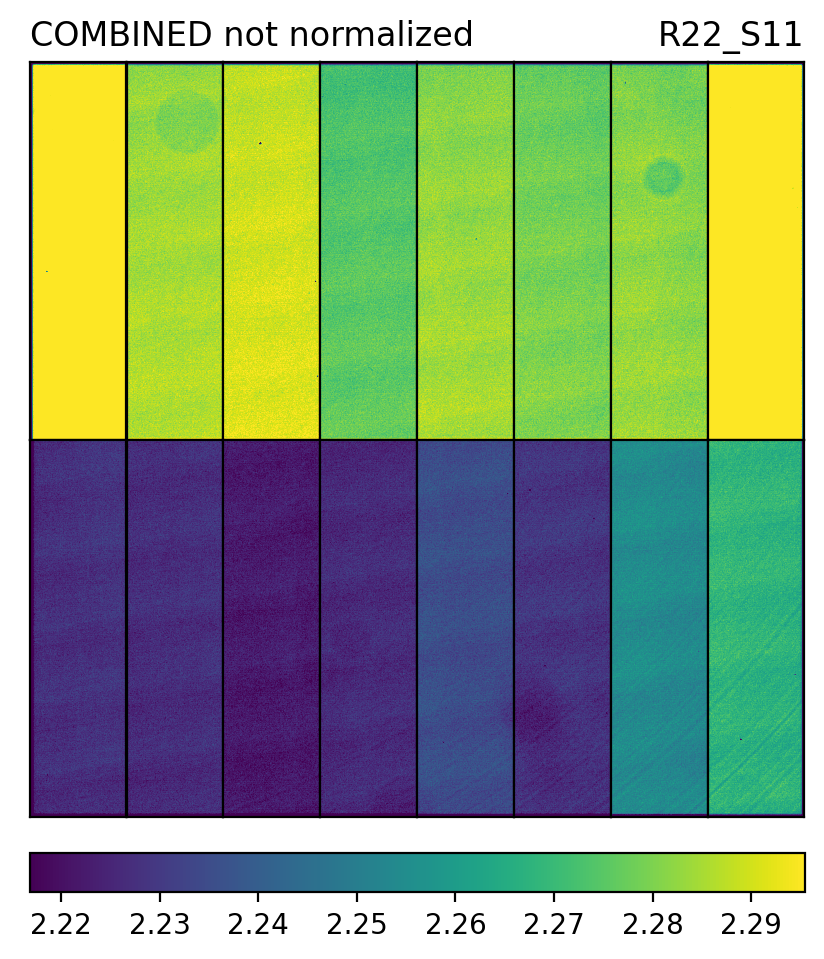

In [5]:
fig=plt.figure(figsize=(5, 5), dpi=200)   
columns = 8
rows = 2

wholepixels = numpy.array(img_list_top_row + img_list_bottom_row).flatten()
mean = numpy.mean(wholepixels,dtype=numpy.float64)
std = numpy.std(wholepixels,dtype=numpy.float64)
ax = []

for i in range(1, (columns*rows) + 1):
    if i < 9:
        image_com = np.flipud(np.fliplr(img_list_top_row[i - 1]))
    else:
        image_com = img_list_bottom_row[i - 1 - columns]
        
    ax1 = fig.add_subplot(rows, columns, i)
    ax.append(ax1)
    ax1.set_xticks([])   
    ax1.set_yticks([])
    
    N = 0.5
    
    if i == 1:
        plt.title("COMBINED not normalized", loc='left')
    if i == 8: 
        plt.title("R22_S11", loc='right')
    im = plt.imshow(image_com, vmin=mean-N*std,vmax=mean+N*std,origin="lower")

fig.colorbar(im, ax=ax, orientation="horizontal", anchor=(0,-1))
fig.subplots_adjust(wspace=0, hspace=0)
plt.show()



# This is fine if looking at an image before gain correction. And the COMBINED image is not gain corrected. So it is fine. But I am suspecting that CCOB flat is gain corrected. And it is probably true.
# This looks different than COMBINED. We have another normalization that makes the mean level of COMBINE flat the mean level of CCOB flat, different than here.  

In [6]:
### R22_S11
# here we make the mean flat level of COMBINED matched to the mean flat level of CCOB amplifier-by-amplifier. The purpose of this cell is to normalize the COMBINED flat to the CCOBred.
# here we are normalizing amp-by-amp rather than an overall normalization (before for loop)

red_top = []
red_bot = []
normedimg_top = []
normedimg_bot = []
mean = None

fname = "/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_R22_S11_red_-10.005_10.245.fits"     ##  QE_R22_S11_red_-10.005_10.245.fits ,middle? 
ccob_red = get_ccd_from_id(None, fname, [])

for ch in range(num_ch):
    
    print ( mad_std(get_data_as_read(ccob_red,ch + 1,["imaging"])["imaging"]))
    red = get_data_as_read(ccob_red,ch + 1,["imaging"])["imaging"] 
    
    if ch < columns:
        mean = get_data_as_read(ccob_red,columns-ch,["imaging"])["imaging"].mean()
        normedimg = img_list_top_row[ch]/img_list_top_row[ch].mean()*mean
        normedimg_top.append(normedimg)
        red_top.append(red)
        
    else:
        mean = red.mean()
        normedimg = img_list_bottom_row[ch - columns]/img_list_bottom_row[ch - columns].mean()*mean
        normedimg_bot.append(normedimg)
        red_bot.append(red)
        
    
## reversing the top row image lists to orient sensor mosaic correctly 
red_top.reverse()

401.78520121501816
381.0287701559397
375.09836128191733
370.6505546264005
369.1679524078949
364.7201457523781
364.7201457523781
382.51137237444533
376.5809635004229
361.7549413153669
361.7549413153669
360.2723390968613
361.7549413153669
363.2375435338725
370.6505546264005
389.9243834669733


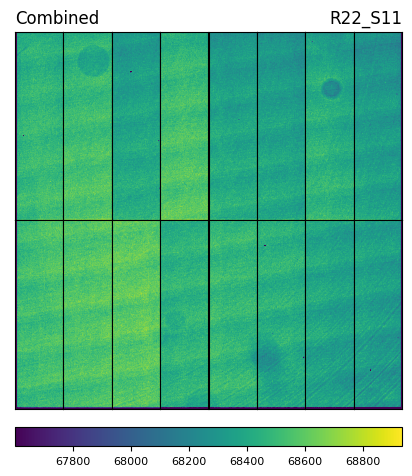

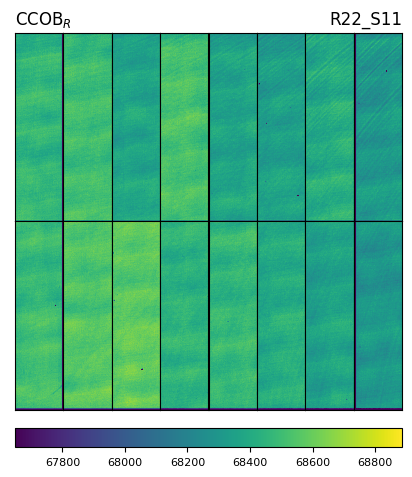

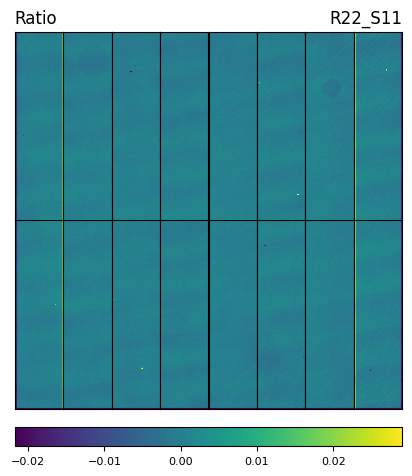

In [17]:
# normedimg flat (combined)

fig=plt.figure(figsize=(5, 5), dpi=100) 
columns = 8
rows = 2

wholepixels = numpy.array(normedimg_top + normedimg_bot).flatten()
mean = numpy.mean(wholepixels,dtype=numpy.float64)
std = numpy.std(wholepixels,dtype=numpy.float64)
ax = []

for i in range(1, (columns*rows) + 1):
    if i < 9:
        image = np.flipud(np.fliplr(normedimg_top[i - 1]))
    else:
        image = normedimg_bot[i - 1 - columns]
        
    ax1 = fig.add_subplot(rows, columns, i)
    ax.append(ax1)
    ax1.set_xticks([])  
    ax1.set_yticks([])
    
    N = 0.3
    
    if i == 1:
        plt.title("Combined", loc='left')
    if i == 8: 
        plt.title("R22_S11", loc='right')
    im = plt.imshow(image, vmin=mean-N*std,vmax=mean+N*std,origin="lower")

cbar = fig.colorbar(im, ax=ax, orientation="horizontal", anchor=(0,-1))
cbar.ax.tick_params(labelsize=8)
fig.subplots_adjust(wspace=0, hspace=0)
plt.show()



# CCOBr flat
fig=plt.figure(figsize=(5, 5), dpi=100)   
columns = 8
rows = 2

wholepixels = numpy.array(red_top + red_bot).flatten()
mean = numpy.mean(wholepixels,dtype=numpy.float64)
std = numpy.std(wholepixels,dtype=numpy.float64)
ax = []

for i in range(1, (columns*rows) + 1):
    if i < 9:
        image = np.flipud(np.fliplr(red_top[i - 1]))
        
    else:
        image = red_bot[i - 1 - columns]
        
    ax1 = fig.add_subplot(rows, columns, i)
    ax.append(ax1)
    ax1.set_xticks([])  
    ax1.set_yticks([])
    
    N = 0.3
    
    if i == 1:
        plt.title(r"CCOB$_{R}$", loc='left')
    if i == 8: 
        plt.title("R22_S11", loc='right')
    im = plt.imshow(image, vmin=mean-N*std,vmax=mean+N*std,origin="lower")

cbar = fig.colorbar(im, ax=ax, orientation="horizontal", anchor=(0,-1))
cbar.ax.tick_params(labelsize=8)
fig.subplots_adjust(wspace=0, hspace=0)
plt.show()



# ratio flat
fig=plt.figure(figsize=(5, 5), dpi=100)   
columns = 8
rows = 2

array = (numpy.array(normedimg_top) - numpy.array(red_top)) / numpy.array(red_top) + (numpy.array(normedimg_bot) - numpy.array(red_bot)) / numpy.array(red_bot)
wholepixels = numpy.array(array).flatten()
mean = numpy.mean(wholepixels,dtype=numpy.float64)
std = numpy.std(wholepixels,dtype=numpy.float64)
ax = []

for i in range(1, (columns*rows) + 1):                              
    if i < 9:
        image = np.flipud(np.fliplr(((normedimg_top[i - 1]) - (red_top[i - 1])) / (red_top[i - 1])))
    else:
        image = ((normedimg_bot[i - 1 - columns]) - (red_bot[i - 1 - columns])) / (red_bot[i - 1 - columns])

    ax1 = fig.add_subplot(rows, columns, i)
    ax.append(ax1)
    ax1.set_xticks([])   
    ax1.set_yticks([])
    if i == 1:
        plt.title("Ratio", loc='left')
    if i == 8: 
        plt.title("R22_S11", loc='right')
    N = 0.3
    im = plt.imshow(image, vmin=mean-N*std,vmax=mean+N*std,origin="lower")

cbar = fig.colorbar(im, ax=ax, orientation="horizontal", anchor=(0,-1))
cbar.ax.tick_params(labelsize=8)   
fig.subplots_adjust(wspace=0, hspace=0)
plt.show()

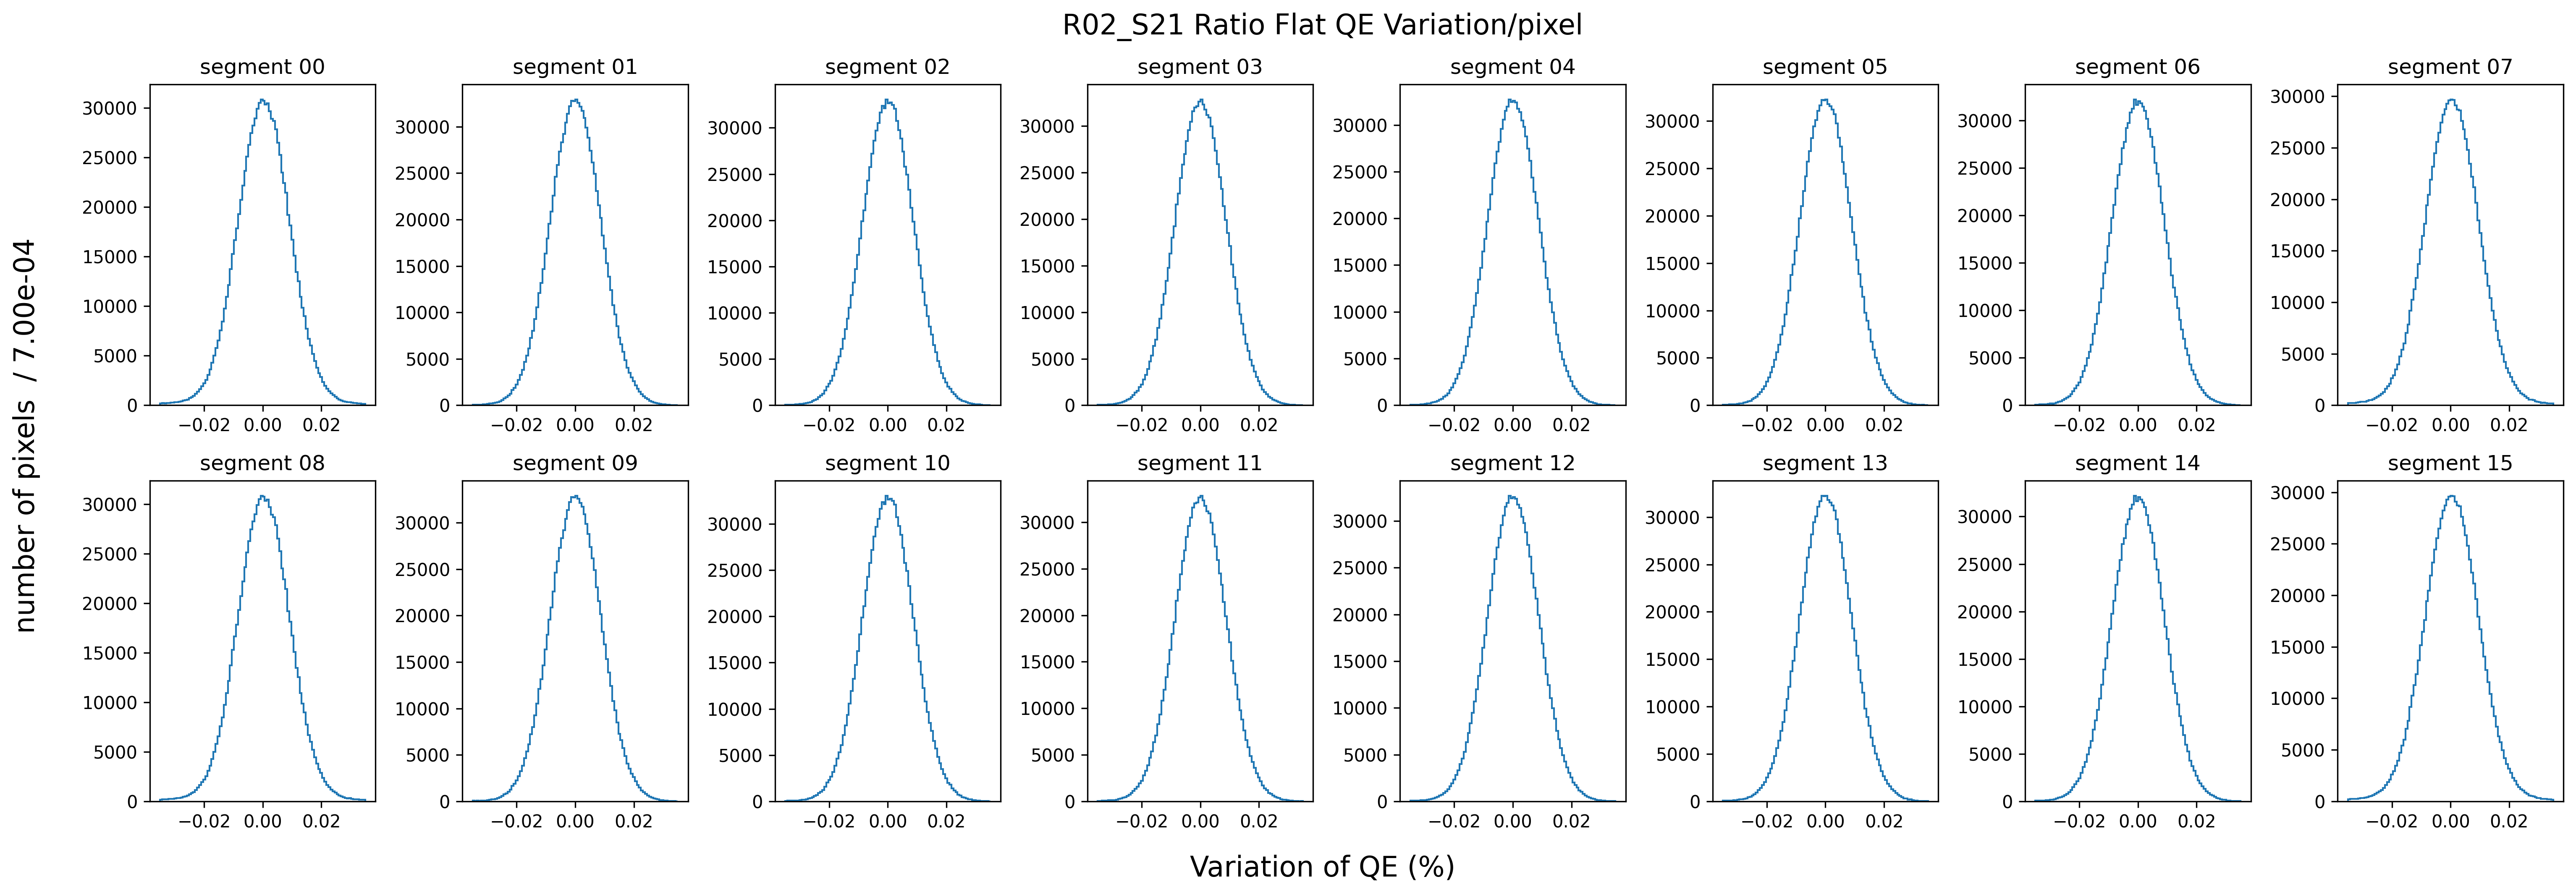

In [13]:
xmin= -0.035
xmax= 0.035
nbins= 101
bins= np.linspace(xmin, xmax, nbins)
width = (xmax-xmin)/ (nbins-1)


# creating histogram plots for R22_S11 ratio
fig, axs = plt.subplots(2, 8, figsize=(20,7),dpi=300) 
rows = 2    
columns = 8 
axs = axs.ravel()

fig.suptitle('R02_S21 Ratio Flat QE Variation/pixel', fontsize=16)
fig.text(0.5, 0.0, "Variation of QE (%)", ha='center', fontsize=16)
fig.text(-0.02, 0.5, "number of pixels  / %.2e" % width, va='center', rotation='vertical', fontsize=16)

for i in range(16):
    if i < 8:
        x = (normedimg_bot[i] - red_bot[i]) / red_bot[i]     
    else:
        x = (normedimg_bot[i - columns] - red_bot[i - columns]) / red_bot[i - columns]
    
    axs[i].hist(x.flat, bins=bins, histtype='step')
    
    if i > 9:
        axs[i].set_title("segment " + str(i))
    else:
        axs[i].set_title("segment 0" + str(i))
    
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [12]:
x.min(), x.max()


(-0.9034699, 4.9422493)

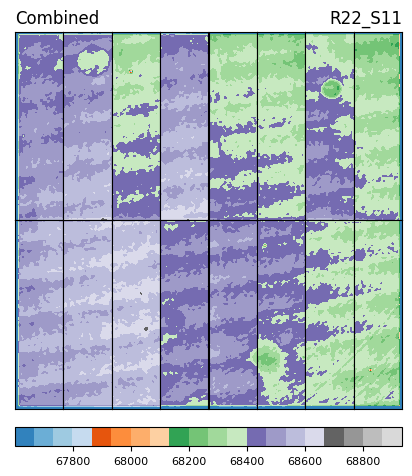

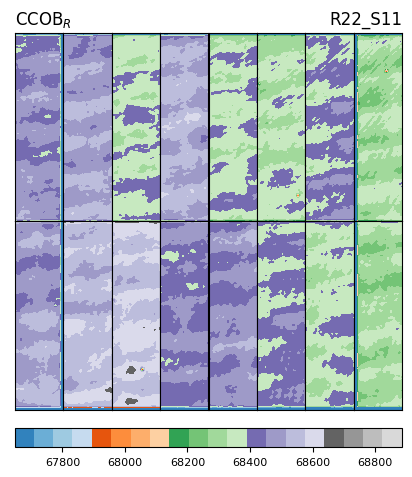

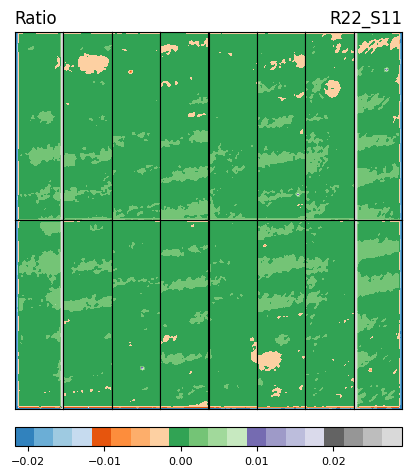

In [18]:
                                                                        # SMOOTHED #
from scipy.ndimage import gaussian_filter
    
    
# normedimg flat (combined)
fig=plt.figure(figsize=(5, 5), dpi=100) 
columns = 8
rows = 2

wholepixels = numpy.array(normedimg_top + normedimg_bot).flatten()
mean = numpy.mean(wholepixels,dtype=numpy.float64)
std = numpy.std(wholepixels,dtype=numpy.float64)
ax = []

for i in range(1, (columns*rows) + 1):
    if i < 9:
        image = np.flipud(np.fliplr(normedimg_top[i - 1]))
    else:
        image = normedimg_bot[i - 1 - columns]
        
    ax1 = fig.add_subplot(rows, columns, i)
    ax.append(ax1)
    ax1.set_xticks([])  
    ax1.set_yticks([])
    
    N = 0.3
    
    if i == 1:
        plt.title("Combined", loc='left')
    if i == 8: 
        plt.title("R22_S11", loc='right')
        
    sigma=10              # changes width of smoothing
    im = plt.imshow(gaussian_filter(image,sigma=sigma),vmin=mean-N*std,vmax=mean+N*std,origin="lower",cmap=pylab.get_cmap("tab20c"))

cbar = fig.colorbar(im, ax=ax, orientation="horizontal", anchor=(0,-1))
cbar.ax.tick_params(labelsize=8)
fig.subplots_adjust(wspace=0, hspace=0)
plt.show()



# CCOBr flat
fig=plt.figure(figsize=(5, 5), dpi=100)   
columns = 8
rows = 2

wholepixels = numpy.array(red_top + red_bot).flatten()
mean = numpy.mean(wholepixels,dtype=numpy.float64)
std = numpy.std(wholepixels,dtype=numpy.float64)
ax = []

for i in range(1, (columns*rows) + 1):
    if i < 9:
        image = np.flipud(np.fliplr(red_top[i - 1]))
        
    else:
        image = red_bot[i - 1 - columns]
        
    ax1 = fig.add_subplot(rows, columns, i)
    ax.append(ax1)
    ax1.set_xticks([])  
    ax1.set_yticks([])
    
    N = 0.3
    
    if i == 1:
        plt.title(r"CCOB$_{R}$", loc='left')
    if i == 8: 
        plt.title("R22_S11", loc='right')
        
    sigma=10              
    im = plt.imshow(gaussian_filter(image,sigma=sigma),vmin=mean-N*std,vmax=mean+N*std,origin="lower",cmap=pylab.get_cmap("tab20c"))

cbar = fig.colorbar(im, ax=ax, orientation="horizontal", anchor=(0,-1))
cbar.ax.tick_params(labelsize=8)
fig.subplots_adjust(wspace=0, hspace=0)
plt.show()



# ratio flat
fig=plt.figure(figsize=(5, 5), dpi=100)   
columns = 8
rows = 2

array = (numpy.array(normedimg_top) - numpy.array(red_top)) / numpy.array(red_top) + (numpy.array(normedimg_bot) - numpy.array(red_bot)) / numpy.array(red_bot)
wholepixels = numpy.array(array).flatten()
mean = numpy.mean(wholepixels,dtype=numpy.float64)
std = numpy.std(wholepixels,dtype=numpy.float64)
ax = []

for i in range(1, (columns*rows) + 1):                              
    if i < 9:
        image = np.flipud(np.fliplr(((normedimg_top[i - 1]) - (red_top[i - 1])) / (red_top[i - 1])))
    else:
        image = ((normedimg_bot[i - 1 - columns]) - (red_bot[i - 1 - columns])) / (red_bot[i - 1 - columns])

    ax1 = fig.add_subplot(rows, columns, i)
    ax.append(ax1)
    ax1.set_xticks([])   
    ax1.set_yticks([])
    if i == 1:
        plt.title("Ratio", loc='left')
    if i == 8: 
        plt.title("R22_S11", loc='right')
        
    N = 0.3
    sigma=10              
    im = plt.imshow(gaussian_filter(image,sigma=sigma),vmin=mean-N*std,vmax=mean+N*std,origin="lower",cmap=pylab.get_cmap("tab20c"))

cbar = fig.colorbar(im, ax=ax, orientation="horizontal", anchor=(0,-1))
cbar.ax.tick_params(labelsize=8)   
fig.subplots_adjust(wspace=0, hspace=0)
plt.show()